# Description

It analyzes how correlation coefficients intersect on different gene pairs. Basically, I take the top gene pairs with the maximum correlation coefficient according to Pearson, Spearman and Clustermatch, and also the equivalent set with the minimum coefficient values, and then compare how these sets intersect each other.

After identifying different intersection sets, I plot some gene pairs to see what's being captured or not by each coefficient.

# Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import plot, from_indicators

from clustermatch.plots import MyUpSet
from clustermatch import conf

# Settings

In [2]:
DATASET_CONFIG = conf.GTEX
GTEX_TISSUE = "whole_blood"
GENE_SEL_STRATEGY = "var_pc_log2"

In [3]:
# this specificies the threshold to compare coefficients (see below).
# it basically takes the top Q_DIFF coefficient values for gene pairs
# and compare with the bottom Q_DIFF of the other coefficients
Q_DIFF = 0.30

# Paths

In [4]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [5]:
OUTPUT_FIGURE_DIR = (
    conf.MANUSCRIPT["FIGURES_DIR"] / "coefs_comp" / f"gtex_{GTEX_TISSUE}"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/gtex_whole_blood')

In [6]:
INPUT_GENE_EXPR_FILE = (
    DATASET_CONFIG["GENE_SELECTION_DIR"]
    / f"gtex_v8_data_{GTEX_TISSUE}-{GENE_SEL_STRATEGY}.pkl"
)
display(INPUT_GENE_EXPR_FILE)

assert INPUT_GENE_EXPR_FILE.exists()

PosixPath('/opt/data/results/gtex_v8/gene_selection/gtex_v8_data_whole_blood-var_pc_log2.pkl')

In [7]:
INPUT_CORR_FILE_TEMPLATE = (
    DATASET_CONFIG["SIMILARITY_MATRICES_DIR"]
    / DATASET_CONFIG["SIMILARITY_MATRIX_FILENAME_TEMPLATE"]
)
display(INPUT_CORR_FILE_TEMPLATE)

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_{tissue}-{gene_sel_strategy}-{corr_method}.pkl')

In [8]:
INPUT_CORR_FILE = DATASET_CONFIG["SIMILARITY_MATRICES_DIR"] / str(
    INPUT_CORR_FILE_TEMPLATE
).format(
    tissue=GTEX_TISSUE,
    gene_sel_strategy=GENE_SEL_STRATEGY,
    corr_method="all",
)
display(INPUT_CORR_FILE)

assert INPUT_CORR_FILE.exists()

PosixPath('/opt/data/results/gtex_v8/similarity_matrices/gtex_v8_data_whole_blood-var_pc_log2-all.pkl')

# Data

## Gene Ensembl ID -> Symbol mapping

In [9]:
gene_map = pd.read_pickle(
    DATASET_CONFIG["DATA_DIR"] / "gtex_gene_id_symbol_mappings.pkl"
)

In [10]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [11]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

## Gene expression

In [12]:
gene_expr_df = pd.read_pickle(INPUT_GENE_EXPR_FILE)

In [13]:
gene_expr_df.shape

(5000, 755)

In [14]:
gene_expr_df.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000169429.10,0.5623,0.8067,116.90000,4.047,211.0,58.110,68.38,249.50,5.095,295.9,...,39.960,0.1393,0.22380,245.0,513.6,1626.00,0.5633,515.70,1.19400,1163.00
ENSG00000135245.9,0.6529,1.3850,199.20000,2.266,116.7,192.300,161.50,263.50,23.540,251.9,...,114.300,1.8330,0.41150,149.0,935.3,233.60,0.8882,134.00,1.12000,295.70
ENSG00000163631.16,1.8480,0.2503,0.08429,1.251,1348.0,9.971,101.30,95.09,1.264,119.3,...,2.092,2.1100,0.03588,171.8,107.1,71.25,1.7720,309.60,0.07361,17.75
ENSG00000277632.1,1.6960,1.3450,235.10000,11.770,141.7,199.100,525.50,659.90,10.910,209.3,...,61.340,2.2500,0.72310,261.2,400.0,288.50,2.6960,287.50,3.32300,618.90
ENSG00000239839.6,185.2000,1.7790,694.30000,23.840,297.3,3122.000,2521.00,1504.00,80.060,652.0,...,1010.000,253.8000,94.52000,6083.0,2768.0,52.06,34.5700,17.36,352.30000,63.85


## Correlation

In [15]:
df = pd.read_pickle(INPUT_CORR_FILE)

In [16]:
df.shape

(12497500, 3)

In [17]:
df.head()

clustermatch   pearson  spearman
ENSG00000000419.12 ENSG00000002834.17      0.418721  0.681847  0.786595
                   ENSG00000002919.14      0.405090  0.734699  0.816991
                   ENSG00000002933.7       0.007466  0.013825  0.004128
                   ENSG00000003402.19      0.391683  0.727347  0.803653
                   ENSG00000004478.7       0.099013  0.094147  0.231269

In [18]:
# FIXME: this will not be necessary in new runs of clustermatch on GTEx
df.loc[df["clustermatch"] < 0, "clustermatch"] = 0.0

In [19]:
df.describe()

,clustermatch,pearson,spearman
count,1.249750e+07,1.249750e+07,1.249750e+07
mean,1.407816e-01,3.055270e-01,3.944421e-01
std,1.448215e-01,2.432962e-01,2.595311e-01
min,0.000000e+00,1.507747e-08,1.394156e-08
25%,2.840490e-02,9.442322e-02,1.629740e-01
50%,8.111060e-02,2.388613e-01,3.675595e-01
75%,2.167198e-01,4.953854e-01,6.148954e-01
max,9.169180e-01,9.948780e-01,9.867424e-01


In [20]:
# show quantiles
df.apply(lambda x: x.quantile(np.linspace(0.20, 1.0, 20)))

,clustermatch,pearson,spearman
0.200000,0.022719,0.072940,0.128198
0.242105,0.027466,0.090891,0.157408
0.284211,0.032678,0.110196,0.187676
0.326316,0.038882,0.131066,0.219424
0.368421,0.046496,0.153705,0.253012
0.410526,0.054956,0.178290,0.288341
0.452632,0.065748,0.205194,0.324886
0.494737,0.079110,0.234929,0.362750
0.536842,0.094529,0.267921,0.401768
0.578947,0.112897,0.304762,0.441738


# Prepare data for plotting

In [21]:
def get_lower_upper_quantile(method_name, q):
    return df[method_name].quantile([q, 1 - q])

In [22]:
# test
_tmp = get_lower_upper_quantile("clustermatch", 0.20)
display(_tmp)

_tmp0, _tmp1 = _tmp
display((_tmp0, _tmp1))

assert _tmp0 == _tmp.iloc[0]
assert _tmp1 == _tmp.iloc[1]

0.2    0.022719
0.8    0.259050
Name: clustermatch, dtype: float64

(0.02271880444305697, 0.259049765543866)

In [23]:
clustermatch_lq, clustermatch_hq = get_lower_upper_quantile("clustermatch", Q_DIFF)
display((clustermatch_lq, clustermatch_hq))

pearson_lq, pearson_hq = get_lower_upper_quantile("pearson", Q_DIFF)
display((pearson_lq, pearson_hq))

spearman_lq, spearman_hq = get_lower_upper_quantile("spearman", Q_DIFF)
display((spearman_lq, spearman_hq))

(0.034958339010692396, 0.18194034996376532)

(0.11783518340101658, 0.43471104354487755)

(0.1993565001342337, 0.5627397462227566)

In [24]:
pearson_higher = df["pearson"] >= pearson_hq
display(pearson_higher.sum())

pearson_lower = df["pearson"] <= pearson_lq
display(pearson_lower.sum())

3749250

3749250

In [25]:
spearman_higher = df["spearman"] >= spearman_hq
display(spearman_higher.sum())

spearman_lower = df["spearman"] <= spearman_lq
display(spearman_lower.sum())

3749250

3749250

In [26]:
clustermatch_higher = df["clustermatch"] >= clustermatch_hq
display(clustermatch_higher.sum())

clustermatch_lower = df["clustermatch"] <= clustermatch_lq
display(clustermatch_lower.sum())

3754664

3749265

# UpSet plot

In [27]:
df_plot = pd.DataFrame(
    {
        "pearson_higher": pearson_higher,
        "pearson_lower": pearson_lower,
        "spearman_higher": spearman_higher,
        "spearman_lower": spearman_lower,
        "clustermatch_higher": clustermatch_higher,
        "clustermatch_lower": clustermatch_lower,
    }
)

In [28]:
df_plot = pd.concat([df_plot, df], axis=1)

In [29]:
df_plot

pearson_higher  pearson_lower  \
ENSG00000000419.12 ENSG00000002834.17            True          False   
                   ENSG00000002919.14            True          False   
                   ENSG00000002933.7            False           True   
                   ENSG00000003402.19            True          False   
                   ENSG00000004478.7            False           True   
...                                               ...            ...   
ENSG00000284574.1  ENSG00000282651.2            False           True   
                   ENSG00000282780.1            False           True   
                   ENSG00000282939.1            False           True   
                   ENSG00000283063.1            False           True   
                   ENSG00000283602.1            False           True   

                                       spearman_higher  spearman_lower  \
ENSG00000000419.12 ENSG00000002834.17             True           False   
                   ENSG00000002919.14             True           False   
                   ENSG00000002933.7             False            True   
                   ENSG00000003402.19             True           False   
                   ENSG00000004478.7             False           False   
...                                                ...             ...   
ENSG00000284574.1  ENSG00000282651.2             False            True   
                   ENSG00000282780.1             False            True   
                   ENSG00000282939.1             False            True   
                   ENSG00000283063.1             False            True   
                   ENSG00000283602.1             False            True   

                                       clustermatch_higher  \
ENSG00000000419.12 ENSG00000002834.17                 True   
                   ENSG00000002919.14                 True   
                   ENSG00000002933.7                 False   
                   ENSG00000003402.19                 True   
                   ENSG00000004478.7                 False   
...                                                    ...   
ENSG00000284574.1  ENSG00000282651.2                 False   
                   ENSG00000282780.1                 False   
                   ENSG00000282939.1                 False   
                   ENSG00000283063.1                 False   
                   ENSG00000283602.1                 False   

                                       clustermatch_lower  clustermatch  \
ENSG00000000419.12 ENSG00000002834.17               False      0.418721   
                   ENSG00000002919.14               False      0.405090   
                   ENSG00000002933.7                 True      0.007466   
                   ENSG00000003402.19               False      0.391683   
                   ENSG00000004478.7                False      0.099013   
...                                                   ...           ...   
ENSG00000284574.1  ENSG00000282651.2                 True      0.011968   
                   ENSG00000282780.1                 True      0.004975   
                   ENSG00000282939.1                 True      0.011968   
                   ENSG00000283063.1                 True      0.006638   
                   ENSG00000283602.1                 True      0.013967   

                                        pearson  spearman  
ENSG00000000419.12 ENSG00000002834.17  0.681847  0.786595  
                   ENSG00000002919.14  0.734699  0.816991  
                   ENSG00000002933.7   0.013825  0.004128  
                   ENSG00000003402.19  0.727347  0.803653  
                   ENSG00000004478.7   0.094147  0.231269  
...                                         ...       ...  
ENSG00000284574.1  ENSG00000282651.2   0.051215  0.089428  
                   ENSG00000282780.1   0.031741  0.018411  
                   ENSG00000282939.1   0.029699  0.104518  
                   ENSG00000283063.1   

In [30]:
assert not df_plot.isna().any().any()

In [31]:
df_plot = df_plot.rename(
    columns={
        "pearson_higher": "Pearson (high)",
        "pearson_lower": "Pearson (low)",
        "spearman_higher": "Spearman (high)",
        "spearman_lower": "Spearman (low)",
        "clustermatch_higher": "Clustermatch (high)",
        "clustermatch_lower": "Clustermatch (low)",
    }
)

In [32]:
categories = sorted(
    [x for x in df_plot.columns if " (" in x],
    reverse=True,
    key=lambda x: x.split(" (")[1] + " (" + x.split(" (")[0],
)

In [33]:
categories

['Spearman (low)',
 'Pearson (low)',
 'Clustermatch (low)',
 'Spearman (high)',
 'Pearson (high)',
 'Clustermatch (high)']

## All subsets (original full plot)

In [34]:
df_r_data = df_plot

In [35]:
df_r_data.shape

(12497500, 9)

In [36]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [37]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
                                                                               True                           True   
True           True          True               False           False          False                         False   
False          False         False              True            True           True                           True   
               True          False              False           False          False                         False   
...                                                                                                            ...   
True           True          True               False           False          False                         False   
                                                                               False                         False   
                                                                               False                         False   
                                                                               False                         False   
                                                                               False                         False   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
                                                                               True                         False   
True           True          True               False           False          False                         True   
False          False         False              True            True           True                         False   
               True          False              False           False          False                         True   
...                                                                                                           ...   
True           True          True               False           False          False                         True   
                                                                               False                         True   
                                                                               False                         True   
                                                                               False                         True   
                                                                               False                         True   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
                                                                               True                            True   
True           True          True               False           False          False                          False   
False          False         False              True            True           True                            True   
               True          False              False           False          False                          False   
...                                                                                                             ...   
True           True          True               False           False          False       

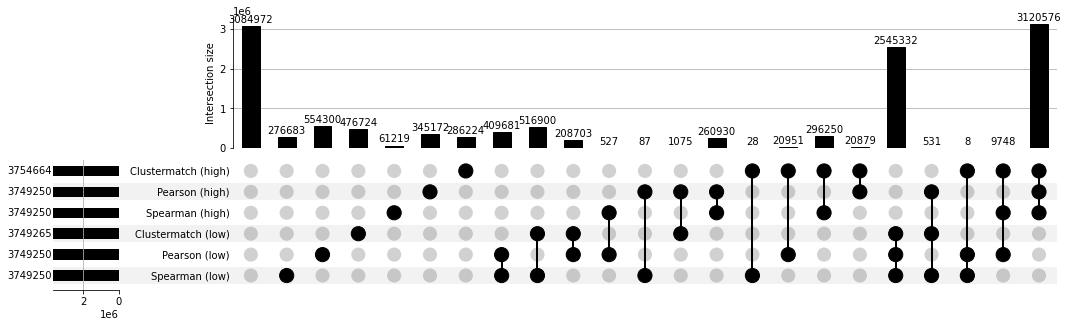

In [38]:
fig = plt.figure(figsize=(18, 5))

g = plot(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    element_size=None,
    fig=fig,
)

## Remove subsets of size one

I leave this part commented out just in case it is useful in the future.

In [39]:
# # remove cases that are found only in one group
# df_r_data = df_plot[df_plot[categories].sum(axis=1) > 1]
# display(df_r_data.shape)

In [40]:
# df_r_data.shape

In [41]:
# gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [42]:
# fig = plt.figure(figsize=(15, 5))

# g = plot(
#     gene_pairs_by_cats,
#     show_counts=True,
#     sort_categories_by=None,
#     element_size=None,
#     fig=fig,
# )

# g["totals"].set_visible(False)

## Remove non-interesting subsets

I leave this part commented out just in case it is useful in the future.

In [43]:
# lower_columns = [x for x in categories if x.endswith("_lower")]
# display(lower_columns)

# higher_columns = [x for x in categories if x.endswith("_higher")]
# display(higher_columns)

In [44]:
# df_r_data = df_plot[
#     (df_plot[categories].sum(axis=1) > 1)
#     & ~(
#         (df_plot[lower_columns].sum(axis=1).isin((0, 3)))
#         & (df_plot[higher_columns].sum(axis=1).isin((0, 3)))
#     )
# ]

In [45]:
# df_r_data.shape

In [46]:
# gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [47]:
# fig = plt.figure(figsize=(17, 5))

# g = plot(
#     gene_pairs_by_cats,
#     show_counts=True,
#     sort_categories_by=None,
#     element_size=None,
#     fig=fig,
# )

# g["totals"].set_visible(False)

## Sort by categories of subsets

In [48]:
df_r_data = df_plot

In [49]:
df_r_data.shape

(12497500, 9)

In [50]:
gene_pairs_by_cats = from_indicators(categories, data=df_r_data)

In [51]:
gene_pairs_by_cats

Pearson (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                   
False          False         False              True            True           True                           True   
                                                                               True                           True   
True           True          True               False           False          False                         False   
False          False         False              True            True           True                           True   
               True          False              False           False          False                         False   
...                                                                                                            ...   
True           True          True               False           False          False                         False   
                                                                               False                         False   
                                                                               False                         False   
                                                                               False                         False   
                                                                               False                         False   

                                                                                                    Pearson (low)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                  
False          False         False              True            True           True                         False   
                                                                               True                         False   
True           True          True               False           False          False                         True   
False          False         False              True            True           True                         False   
               True          False              False           False          False                         True   
...                                                                                                           ...   
True           True          True               False           False          False                         True   
                                                                               False                         True   
                                                                               False                         True   
                                                                               False                         True   
                                                                               False                         True   

                                                                                                    Spearman (high)  \
Spearman (low) Pearson (low) Clustermatch (low) Spearman (high) Pearson (high) Clustermatch (high)                    
False          False         False              True            True           True                            True   
                                                                               True                            True   
True           True          True               False           False          False                          False   
False          False         False              True            True           True                            True   
               True          False              False           False          False                          False   
...                                                                                                             ...   
True           True          True               False           False          False       

In [52]:
gene_pairs_by_cats = gene_pairs_by_cats.sort_index()

In [53]:
_tmp_index = gene_pairs_by_cats.index.unique().to_frame(False)
display(_tmp_index)

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
0,False,False,False,False,False,False
1,False,False,False,False,False,True
2,False,False,False,False,True,False
3,False,False,False,False,True,True
4,False,False,False,True,False,False
5,False,False,False,True,False,True
6,False,False,False,True,True,False
7,False,False,False,True,True,True
8,False,False,True,False,False,False
9,False,False,True,False,True,False


In [54]:
_tmp_index[_tmp_index.sum(axis=1) == 3]

,Spearman (low),Pearson (low),Clustermatch (low),Spearman (high),Pearson (high),Clustermatch (high)
7,False,False,False,True,True,True
13,False,True,False,True,False,True
19,True,False,True,False,True,False
21,True,True,False,False,False,True
22,True,True,True,False,False,False


In [55]:
_tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
dtype: bool

In [56]:
# agreements on top
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() == 0, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[3:].sum() > 1, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, False, False, True, True),
       (False, False, False, True, False, True),
       (False, False, False, True, True, False)], dtype=object)

In [57]:
# agreements on bottom
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: 3 > x[0:3].sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() == 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, True, True, False, False, False),
       (True, False, True, False, False, False),
       (True, True, False, False, False, False)], dtype=object)

In [58]:
# diagreements
_tmp_index.loc[
    _tmp_index[
        _tmp_index.apply(lambda x: x.sum() > 1, axis=1)
        & _tmp_index.apply(lambda x: x[0:3].sum() > 0, axis=1)
        & _tmp_index.apply(lambda x: x[3:].sum() > 0, axis=1)
    ].index
].apply(tuple, axis=1).to_numpy()

array([(False, False, True, False, True, False),
       (False, True, False, False, False, True),
       (False, True, False, True, False, False),
       (False, True, False, True, False, True),
       (True, False, False, False, False, True),
       (True, False, False, False, True, False),
       (True, False, True, False, True, False),
       (True, True, False, False, False, True)], dtype=object)

In [59]:
# order subsets
gene_pairs_by_cats = gene_pairs_by_cats.loc[
    [
        # pairs not included in categories:
        # (False, False, False, False, False, False),
        # full agreements on high:
        (False, False, False, True, True, True),
        # agreements on top
        (False, False, False, False, True, True),
        (False, False, False, True, False, True),
        (False, False, False, True, True, False),
        # agreements on bottom
        (False, True, True, False, False, False),
        (True, False, True, False, False, False),
        (True, True, False, False, False, False),
        # full agreements on low:
        (True, True, True, False, False, False),
        # diagreements
        ## clustermatch
        (False, True, False, True, False, True),
        (False, True, False, False, False, True),
        (True, False, False, False, False, True),
        (True, True, False, False, False, True),
        ## pearson
        (False, False, True, False, True, False),
        (True, False, False, False, True, False),
        (True, False, True, False, True, False),
        ## spearman
        (False, True, False, True, False, False),
    ]
]

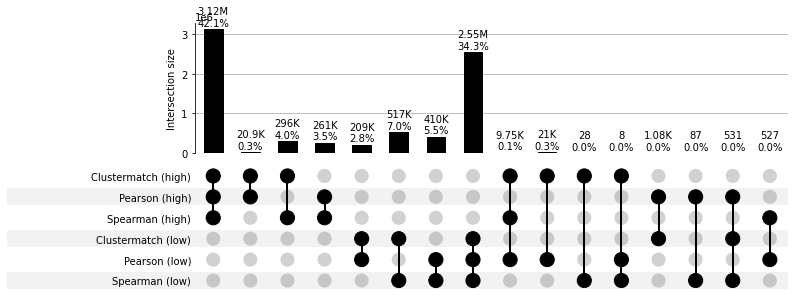

In [60]:
fig = plt.figure(figsize=(14, 5))

# g = plot(
g = MyUpSet(
    gene_pairs_by_cats,
    show_counts=True,
    sort_categories_by=None,
    sort_by=None,
    show_percentages=True,
    # min_subset_size=2,
    element_size=None,
    # fig=fig,
).plot(fig)

g["totals"].remove()  # set_visible(False)

# display(fig.get_size_inches())
# fig.set_size_inches(12, 5)

plt.savefig(
    OUTPUT_FIGURE_DIR / "upsetplot.svg",
    bbox_inches="tight",
    facecolor="white",
)

# plt.margins(x=-0.4)

This plot has the sets that represent agreements on the left, and disagreements on the right. The plot shown here is not the final one for the manuscript.

# Look at specific gene pair cases

In [61]:
def plot_gene_pair(top_pairs_df, idx, bins="log"):
    gene0, gene1 = top_pairs_df.iloc[idx].name
    display((gene0, gene1))

    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    _pearson, _spearman, _clustermatch = top_pairs_df.loc[
        (gene0, gene1), ["pearson", "spearman", "clustermatch"]
    ].tolist()

    _title = f"$c={_clustermatch:.2f}$  $r={_pearson:.2f}$  $r_s={_spearman:.2f}$"

    # displot DOES SUPPORT HUE!
    p = sns.jointplot(
        data=gene_expr_df.T,
        x=gene0,
        y=gene1,
        kind="hex",
        bins=bins,
        # ylim=(0, 500),
    )

    gene_x_id = p.ax_joint.get_xlabel()
    gene_x_symbol = gene_map[gene_x_id]
    p.ax_joint.set_xlabel(f"{gene_x_id}\n{gene_x_symbol}")

    gene_y_id = p.ax_joint.get_ylabel()
    gene_y_symbol = gene_map[gene_y_id]
    p.ax_joint.set_ylabel(f"{gene_y_id}\n{gene_y_symbol}")

    p.fig.suptitle(_title)

    return p

In [62]:
# add columns with ranks
df_r_data = pd.concat(
    [
        df_plot,
        df_plot[["clustermatch", "pearson", "spearman"]]
        .rank()
        .rename(
            columns={
                "clustermatch": "clustermatch_rank",
                "pearson": "pearson_rank",
                "spearman": "spearman_rank",
            }
        ),
    ],
    axis=1,
)

In [63]:
df_r_data.head()

Pearson (high)  Pearson (low)  \
ENSG00000000419.12 ENSG00000002834.17            True          False   
                   ENSG00000002919.14            True          False   
                   ENSG00000002933.7            False           True   
                   ENSG00000003402.19            True          False   
                   ENSG00000004478.7            False           True   

                                       Spearman (high)  Spearman (low)  \
ENSG00000000419.12 ENSG00000002834.17             True           False   
                   ENSG00000002919.14             True           False   
                   ENSG00000002933.7             False            True   
                   ENSG00000003402.19             True           False   
                   ENSG00000004478.7             False           False   

                                       Clustermatch (high)  \
ENSG00000000419.12 ENSG00000002834.17                 True   
                   ENSG00000002919.14                 True   
                   ENSG00000002933.7                 False   
                   ENSG00000003402.19                 True   
                   ENSG00000004478.7                 False   

                                       Clustermatch (low)  clustermatch  \
ENSG00000000419.12 ENSG00000002834.17               False      0.418721   
                   ENSG00000002919.14               False      0.405090   
                   ENSG00000002933.7                 True      0.007466   
                   ENSG00000003402.19               False      0.391683   
                   ENSG00000004478.7                False      0.099013   

                                        pearson  spearman  clustermatch_rank  \
ENSG00000000419.12 ENSG00000002834.17  0.681847  0.786595         11672987.0   
                   ENSG00000002919.14  0.734699  0.816991         11568281.0   
                   ENSG00000002933.7   0.013825  0.004128           508394.5   
                   ENSG00000003402.19  0.727347  0.803653         11457719.5   
                   ENSG00000004478.7   0.094147  0.231269          6842963.0   

                                       pearson_rank  spearman_rank  
ENSG00000000419.12 ENSG00000002834.17    11222956.0     11432918.0  
                   ENSG00000002919.14    11678806.0     11763414.0  
                   ENSG00000002933.7       510967.0        83831.0  
                   ENSG00000003402.19    11619341.0     11623217.0  
                   ENSG00000004478.7      3116619.0      4266789.0

## Clustermatch/Spearman vs Pearson

In [64]:
first_coef = "clustermatch"
second_coefs = ("pearson",)

In [65]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & (df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & ~(df_r_data["Spearman (low)"])
    & (df_r_data["Pearson (low)"])
]

if len(second_coefs) > 1:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"].add(
        _tmp_df[f"{second_coefs[1]}_rank"]
    )
else:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"]

_tmp_df = _tmp_df.assign(rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_second_coefs_sum))

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df.sort_values("rank_diff", ascending=False)

# # sort by firt_coef value
# _tmp_df = _tmp_df.sort_values(
#     first_coef, ascending=False
# )

_tmp_df = _tmp_df[
    [x for x in _tmp_df.columns if "(high)" not in x and "(low)" not in x]
]

display(_tmp_df.shape)
display(_tmp_df)

(9748, 7)

clustermatch   pearson  spearman  \
ENSG00000275385.1  ENSG00000111537.4       0.501466  0.003166  0.688883   
                   ENSG00000143184.4       0.450214  0.012075  0.652067   
ENSG00000136235.15 ENSG00000111537.4       0.408476  0.010980  0.636906   
ENSG00000275385.1  ENSG00000186652.9       0.388366  0.006580  0.628436   
                   ENSG00000100228.12      0.385064  0.008927  0.568386   
...                                             ...       ...       ...   
ENSG00000242114.5  ENSG00000211951.2       0.181940  0.116303  0.574987   
ENSG00000139194.7  ENSG00000070961.15      0.181940  0.116357  0.595486   
ENSG00000108515.17 ENSG00000241657.1       0.181940  0.116835  0.589385   
ENSG00000242114.5  ENSG00000244116.3       0.181940  0.117718  0.576819   
ENSG00000185163.9  ENSG00000159713.10      0.181940  0.117833  0.592530   

                                       clustermatch_rank  pearson_rank  \
ENSG00000275385.1  ENSG00000111537.4          12151145.5      116646.0   
                   ENSG00000143184.4          11885912.5      446762.0   
ENSG00000136235.15 ENSG00000111537.4          11594966.0      406115.0   
ENSG00000275385.1  ENSG00000186652.9          11429470.0      242963.0   
                   ENSG00000100228.12         11400838.0      329891.0   
...                                                  ...           ...   
ENSG00000242114.5  ENSG00000211951.2           8771662.0     3710191.0   
ENSG00000139194.7  ENSG00000070961.15          8771662.0     3711496.0   
ENSG00000108515.17 ENSG00000241657.1           8771662.0     3723668.0   
ENSG00000242114.5  ENSG00000244116.3           8771662.0     3746185.0   
ENSG00000185163.9  ENSG00000159713.10          8771662.0     3749204.0   

                                       spearman_rank   rank_diff  
ENSG00000275385.1  ENSG00000111537.4      10258957.0  12034499.5  
                   ENSG00000143184.4       9815089.0  11439150.5  
ENSG00000136235.15 ENSG00000111537.4       9634211.0  11188851.0  
ENSG00000275385.1  ENSG00000186652.9       9533335.0  11186507.0  
                   ENSG00000100228.12      8816601.0  11070947.0  
...                                              ...         ...  
ENSG00000242114.5  ENSG00000211951.2       8896465.0   5061471.0  
ENSG00000139194.7  ENSG00000070961.15      9141609.0   5060166.0  
ENSG00000108515.17 ENSG00000241657.1       9068808.0   5047994.0  
ENSG00000242114.5  ENSG00000244116.3       8918276.0   5025477.0  
ENSG00000185163.9  ENSG00000159713.10      9106376.0   5022458.0  

[9748 rows x 7 columns]

'Index: 0'

('ENSG00000275385.1', 'ENSG00000111537.4')

('CCL18', 'IFNG')

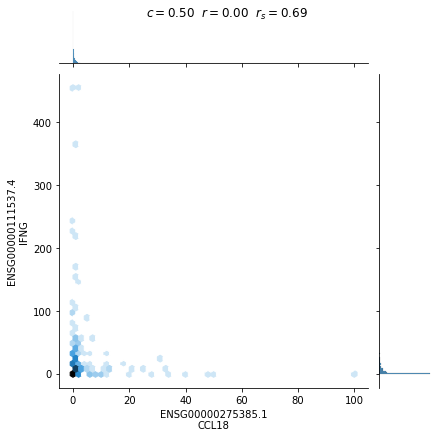

'Index: 1'

('ENSG00000275385.1', 'ENSG00000143184.4')

('CCL18', 'XCL1')

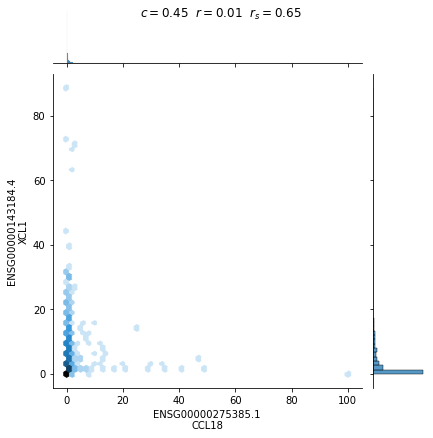

'Index: 2'

('ENSG00000136235.15', 'ENSG00000111537.4')

('GPNMB', 'IFNG')

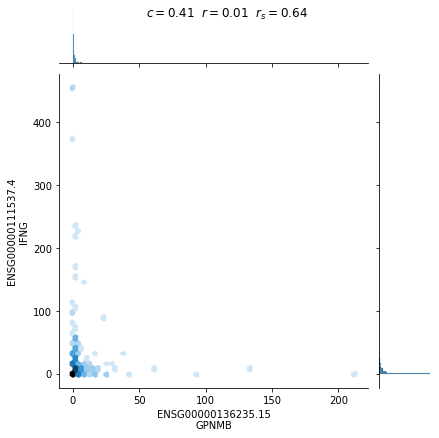

'Index: 3'

('ENSG00000275385.1', 'ENSG00000186652.9')

('CCL18', 'PRG2')

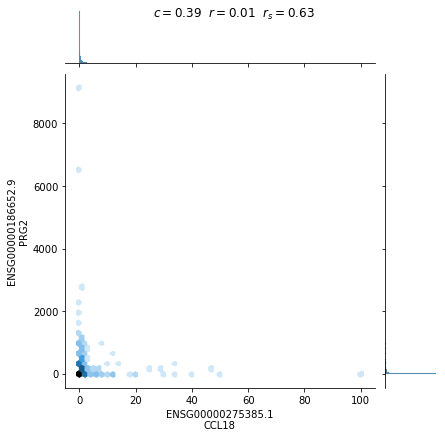

'Index: 4'

('ENSG00000275385.1', 'ENSG00000100228.12')

('CCL18', 'RAB36')

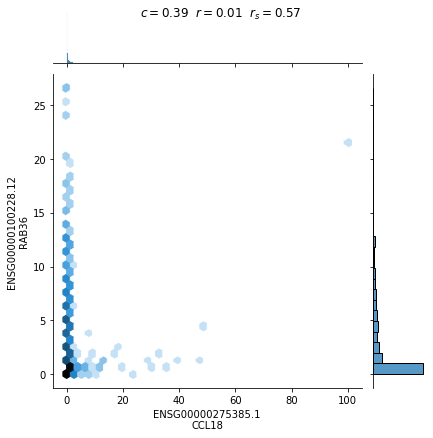

In [66]:
for i in range(min(_tmp_df.shape[0], 5)):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Clustermatch vs Pearson

In [67]:
first_coef = "clustermatch"
second_coefs = ("pearson",)

In [68]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & ~(df_r_data["Spearman (low)"])
    & (df_r_data["Pearson (low)"])
]

if len(second_coefs) > 1:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"].add(
        _tmp_df[f"{second_coefs[1]}_rank"]
    )
else:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"]

_tmp_df = _tmp_df.assign(rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_second_coefs_sum))

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df.sort_values("rank_diff", ascending=False)

# # sort by firt_coef value
# _tmp_df = _tmp_df.sort_values(
#     first_coef, ascending=False
# )

_tmp_df = _tmp_df[
    [x for x in _tmp_df.columns if "(high)" not in x and "(low)" not in x]
]

display(_tmp_df.shape)
display(_tmp_df)

(20951, 7)

,,clustermatch,pearson,spearman,clustermatch_rank,pearson_rank,spearman_rank,rank_diff
ENSG00000120738.7,ENSG00000167552.13,0.334136,0.001009,0.429053,10907101.5,37367.0,7069407.0,10869734.5
ENSG00000236409.1,ENSG00000106211.8,0.418721,0.025810,0.539124,11672987.0,945528.0,8461218.0,10727459.0
ENSG00000068976.13,ENSG00000128342.4,0.321966,0.001978,0.485988,10774663.0,72769.0,7802609.0,10701894.0
ENSG00000079257.7,ENSG00000111537.4,0.418721,0.029649,0.539287,11672987.0,1082557.0,8463186.0,10590430.0
ENSG00000275385.1,ENSG00000196372.12,0.321966,0.005577,0.495846,10774663.0,206065.0,7926331.0,10568598.0
...,...,...,...,...,...,...,...,...
ENSG00000197405.7,ENSG00000130598.15,0.181940,0.117650,0.538947,8771662.0,3744512.0,8459028.0,5027150.0
ENSG00000243649.8,ENSG00000109321.10,0.181940,0.117691,0.525777,8771662.0,3745518.0,8297236.0,5026144.0
ENSG00000187758.7,ENSG00000135821.17,0.181940,0.117743,0.524758,8771662.0,3746868.0,8284681.0,5024794.0
ENSG00000130707.17,ENSG00000170190.15,0.181940,0.117752,0.475810,8771662.0,3747074.0,7673719.0,5024588.0


'Index: 0'

('ENSG00000120738.7', 'ENSG00000167552.13')

('EGR1', 'TUBA1A')

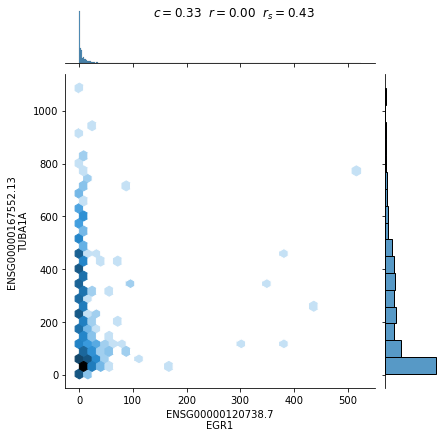

'Index: 1'

('ENSG00000236409.1', 'ENSG00000106211.8')

('NRADDP', 'HSPB1')

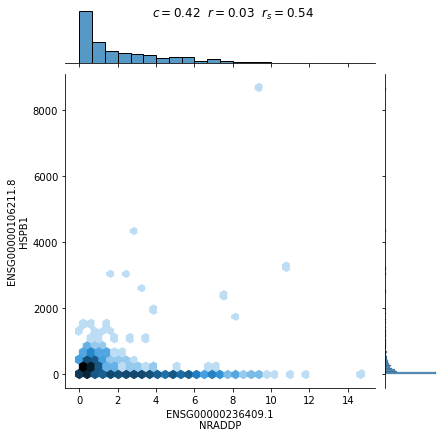

'Index: 2'

('ENSG00000068976.13', 'ENSG00000128342.4')

('PYGM', 'LIF')

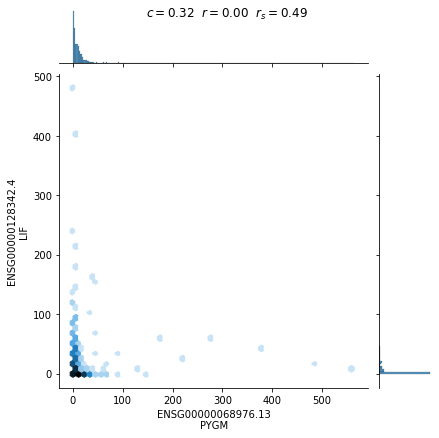

'Index: 3'

('ENSG00000079257.7', 'ENSG00000111537.4')

('LXN', 'IFNG')

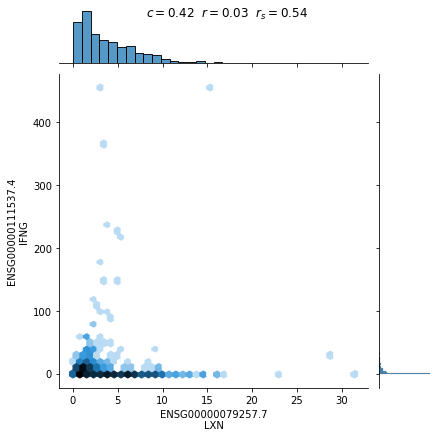

'Index: 4'

('ENSG00000275385.1', 'ENSG00000196372.12')

('CCL18', 'ASB13')

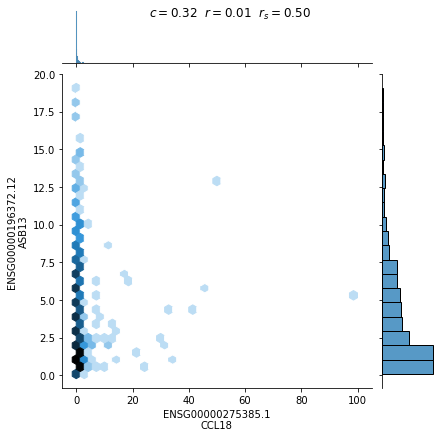

In [69]:
for i in range(min(_tmp_df.shape[0], 5)):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Clustermatch vs Spearman

In [70]:
first_coef = "clustermatch"
second_coefs = ("spearman",)

In [71]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & (df_r_data["Spearman (low)"])
    & ~(df_r_data["Pearson (low)"])
]

if len(second_coefs) > 1:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"].add(
        _tmp_df[f"{second_coefs[1]}_rank"]
    )
else:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"]

_tmp_df = _tmp_df.assign(rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_second_coefs_sum))

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df.sort_values("rank_diff", ascending=False)

# # sort by firt_coef value
# _tmp_df = _tmp_df.sort_values(
#     first_coef, ascending=False
# )

_tmp_df = _tmp_df[
    [x for x in _tmp_df.columns if "(high)" not in x and "(low)" not in x]
]

display(_tmp_df.shape)
display(_tmp_df)

(28, 7)

clustermatch   pearson  spearman  \
ENSG00000147050.14 ENSG00000183878.15      0.294391  0.239870  0.100621   
                   ENSG00000067048.16      0.193557  0.237462  0.035350   
ENSG00000115165.9  ENSG00000235750.9       0.205803  0.158792  0.110038   
                   ENSG00000101265.15      0.201962  0.156060  0.107882   
                   ENSG00000160785.13      0.190192  0.150949  0.098379   
                   ENSG00000105514.7       0.192490  0.237330  0.176075   
                   ENSG00000197324.8       0.184938  0.208519  0.172818   
ENSG00000167378.8  ENSG00000174151.14      0.193464  0.195318  0.181863   
ENSG00000115165.9  ENSG00000241878.11      0.190023  0.241985  0.182072   
ENSG00000064666.14 ENSG00000100226.15      0.193464  0.169898  0.189400   
ENSG00000107771.15 ENSG00000174151.14      0.193464  0.211882  0.190765   
ENSG00000005379.15 ENSG00000174151.14      0.184217  0.166414  0.181505   
ENSG00000196663.15 ENSG00000100226.15      0.193464  0.149426  0.191243   
ENSG00000129925.10 ENSG00000100226.15      0.184217  0.154006  0.181951   
ENSG00000255139.1  ENSG00000101265.15      0.190994  0.165878  0.187627   
ENSG00000198034.10 ENSG00000099725.14      0.198590  0.361447  0.197205   
ENSG00000137275.13 ENSG00000100226.15      0.193464  0.171169  0.196367   
ENSG00000167378.8  ENSG00000143412.9       0.184217  0.201746  0.189370   
ENSG00000168887.10 ENSG00000227782.2       0.181940  0.125835  0.187428   
ENSG00000142599.17 ENSG00000100226.15      0.188812  0.165703  0.194947   
ENSG00000140455.16 ENSG00000100226.15      0.188812  0.179639  0.196454   
ENSG00000107771.15 ENSG00000185905.3       0.188812  0.247591  0.199203   
ENSG00000171608.15 ENSG00000100226.15      0.188812  0.171990  0.199252   
ENSG00000205045.8  ENSG00000130772.13      0.184217  0.200673  0.194881   
ENSG00000198001.13 ENSG00000100226.15      0.184217  0.197282  0.195093   
ENSG00000059804.15 ENSG00000174125.7       0.184217  0.136732  0.195543   
ENSG00000110057.7  ENSG00000100226.15      0.184217  0.166148  0.198736   
ENSG00000107771.15 ENSG00000166272.16      0.181940  0.250624  0.198440   

                                       clustermatch_rank  pearson_rank  \
ENSG00000147050.14 ENSG00000183878.15         10436674.0     6265429.0   
                   ENSG00000067048.16          8989374.0     6225427.0   
ENSG00000115165.9  ENSG00000235750.9           9212181.0     4717121.0   
                   ENSG00000101265.15          9132185.0     4656609.0   
                   ENSG00000160785.13          8908908.0     4542698.0   
                   ENSG00000105514.7           8969241.0     6223245.0   
                   ENSG00000197324.8           8824723.0     5718626.0   
ENSG00000167378.8  ENSG00000174151.14          8979610.0     5469516.0   
ENSG00000115165.9  ENSG00000241878.11          8908632.5     6300106.0   
ENSG00000064666.14 ENSG00000100226.15          8979610.0     4955926.0   
ENSG00000107771.15 ENSG00000174151.14          8979610.0     5780311.0   
ENSG00000005379.15 ENSG00000174151.14          8813629.5     4882101.0   
ENSG00000196663.15 ENSG00000100226.15          8979610.0     4508364.0   
ENSG00000129925.10 ENSG00000100226.15          8813629.5     4611182.0   
ENSG00000255139.1  ENSG00000101265.15          8909722.0     4870717.0   
ENSG00000198034.10 ENSG00000099725.14          9071073.0     7945595.0   
ENSG00000137275.13 ENSG00000100226.15          8979610.0     4982770.0   
ENSG00000167378.8  ENSG00000143412.9           8813629.5     5591743.0   
ENSG00000168887.10 ENSG00000227782.2           8771662.0     3949691.0   
ENSG00000142599.17 ENSG00000100226.15          8897293.5     4866996.0   
ENSG00000140455.16 ENSG00000100226.15          8897293.5     5158131.0   
ENSG00000107771.15 ENSG00000185905.3           8897293.5     6391744.0   
ENSG00000171608.15 ENSG00000100226.15          8897293.5     5000114.0   
ENSG00000205045.8  ENSG00000130772.13          8813629.5     5571687.0   
ENSG000001980

'Index: 0'

('ENSG00000147050.14', 'ENSG00000183878.15')

('KDM6A', 'UTY')

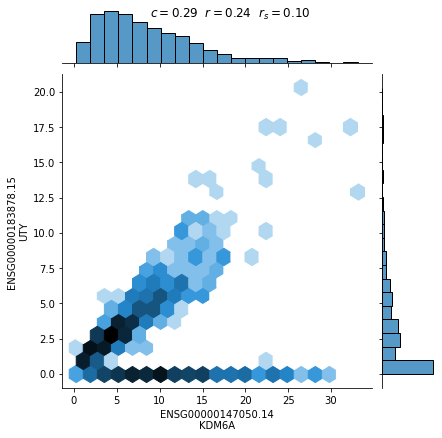

'Index: 1'

('ENSG00000147050.14', 'ENSG00000067048.16')

('KDM6A', 'DDX3Y')

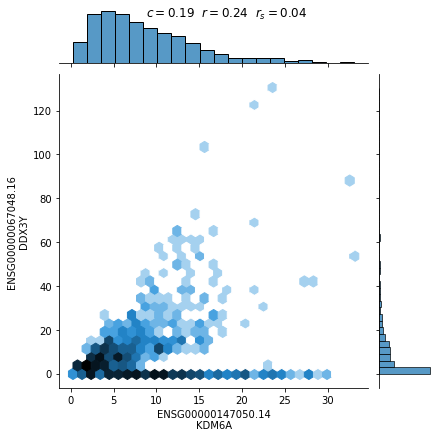

'Index: 2'

('ENSG00000115165.9', 'ENSG00000235750.9')

('CYTIP', 'KIAA0040')

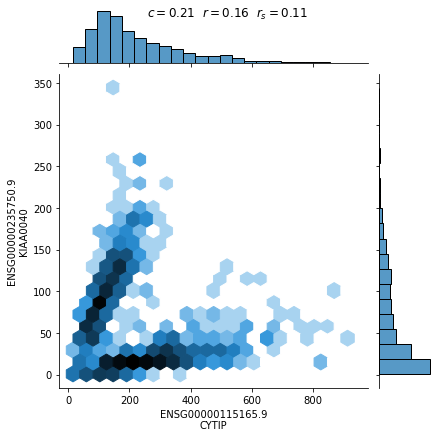

'Index: 3'

('ENSG00000115165.9', 'ENSG00000101265.15')

('CYTIP', 'RASSF2')

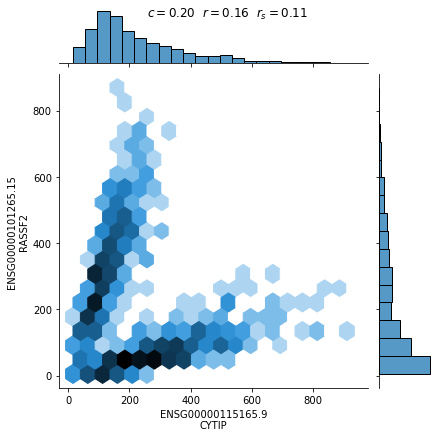

'Index: 4'

('ENSG00000115165.9', 'ENSG00000160785.13')

('CYTIP', 'SLC25A44')

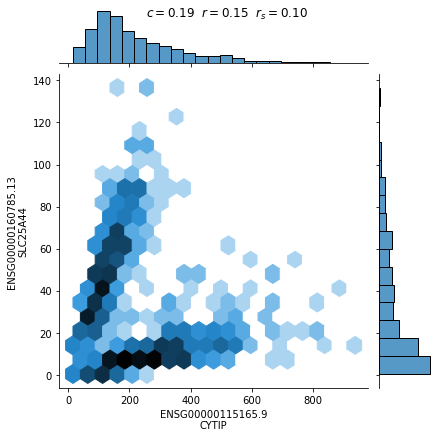

'Index: 5'

('ENSG00000115165.9', 'ENSG00000105514.7')

('CYTIP', 'RAB3D')

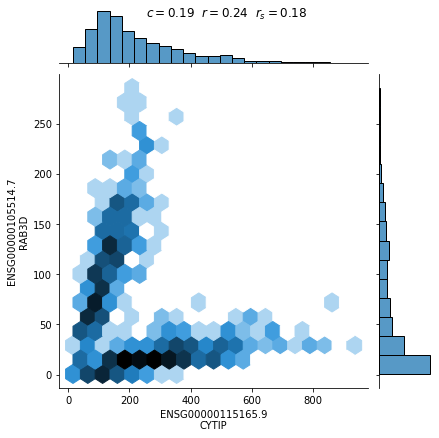

'Index: 6'

('ENSG00000115165.9', 'ENSG00000197324.8')

('CYTIP', 'LRP10')

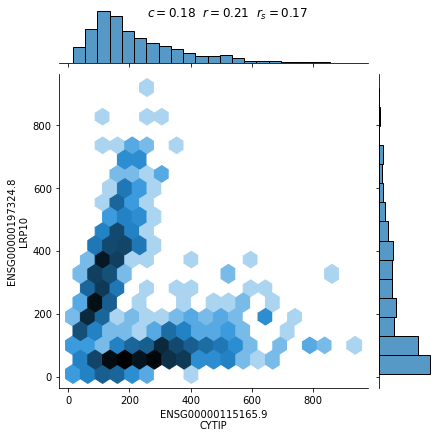

'Index: 7'

('ENSG00000167378.8', 'ENSG00000174151.14')

('IRGQ', 'CYB561D1')

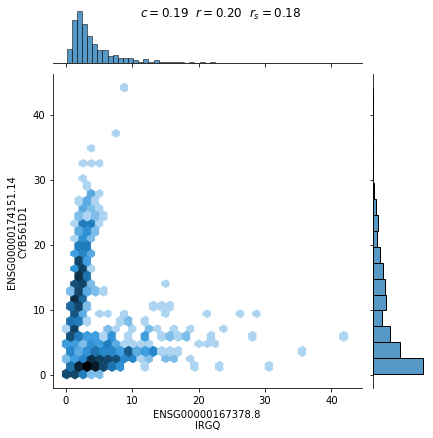

'Index: 8'

('ENSG00000115165.9', 'ENSG00000241878.11')

('CYTIP', 'PISD')

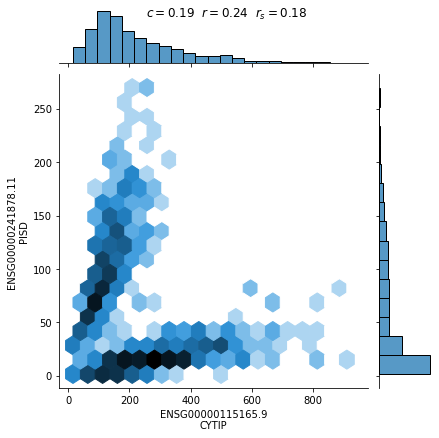

'Index: 9'

('ENSG00000064666.14', 'ENSG00000100226.15')

('CNN2', 'GTPBP1')

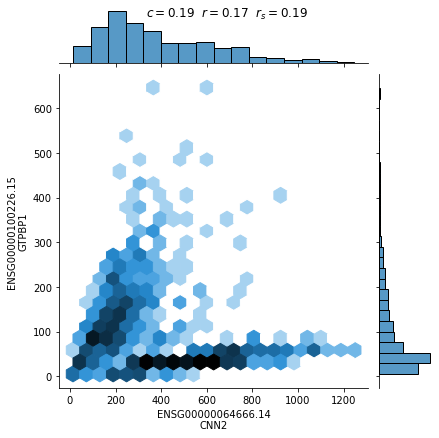

'Index: 10'

('ENSG00000107771.15', 'ENSG00000174151.14')

('CCSER2', 'CYB561D1')

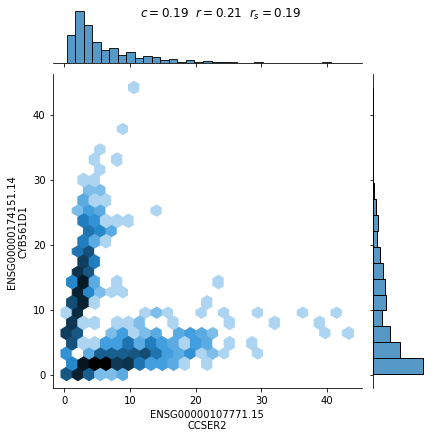

'Index: 11'

('ENSG00000005379.15', 'ENSG00000174151.14')

('TSPOAP1', 'CYB561D1')

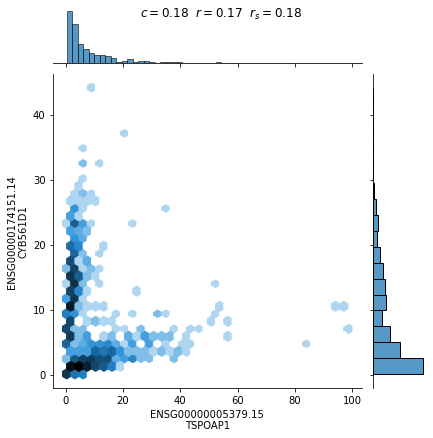

'Index: 12'

('ENSG00000196663.15', 'ENSG00000100226.15')

('TECPR2', 'GTPBP1')

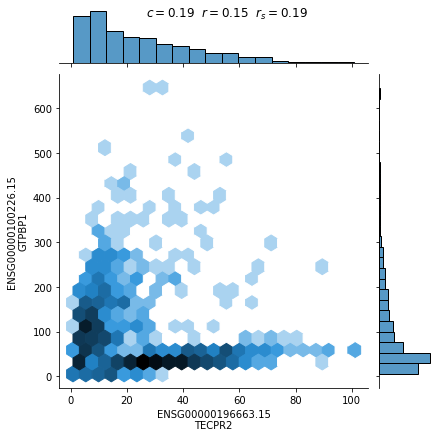

'Index: 13'

('ENSG00000129925.10', 'ENSG00000100226.15')

('TMEM8A', 'GTPBP1')

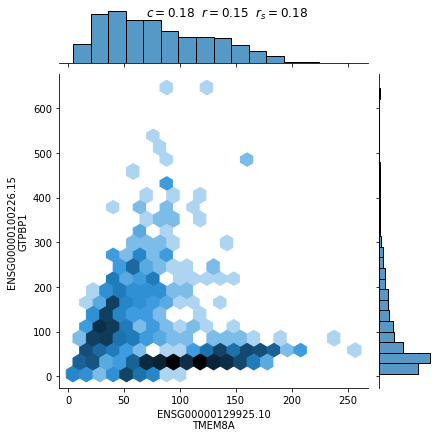

'Index: 14'

('ENSG00000255139.1', 'ENSG00000101265.15')

('AP000442.1', 'RASSF2')

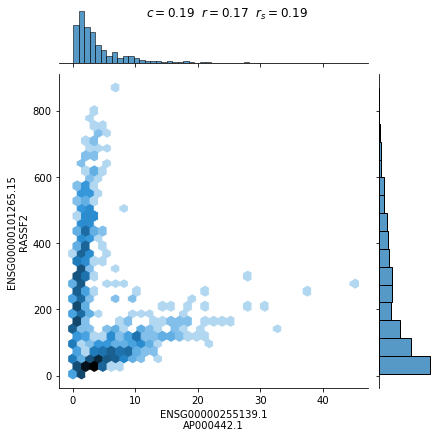

'Index: 15'

('ENSG00000198034.10', 'ENSG00000099725.14')

('RPS4X', 'PRKY')

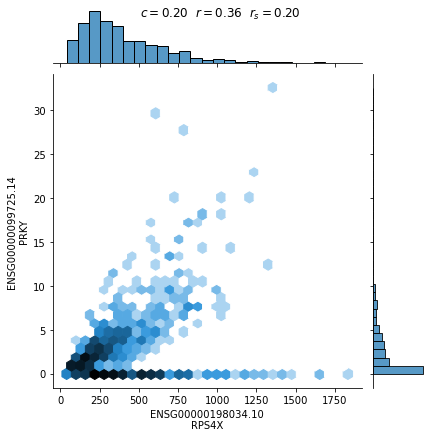

'Index: 16'

('ENSG00000137275.13', 'ENSG00000100226.15')

('RIPK1', 'GTPBP1')

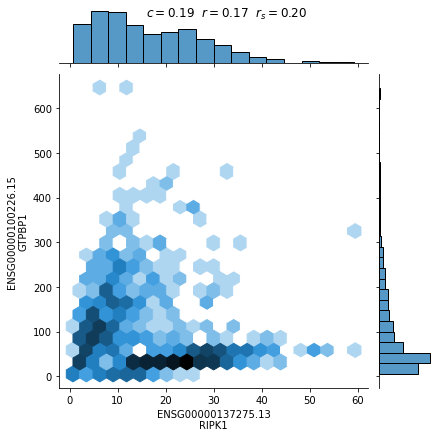

'Index: 17'

('ENSG00000167378.8', 'ENSG00000143412.9')

('IRGQ', 'ANXA9')

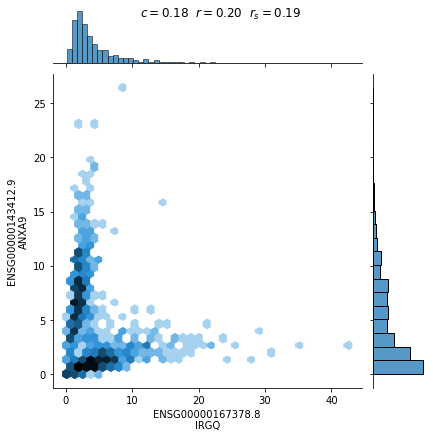

'Index: 18'

('ENSG00000168887.10', 'ENSG00000227782.2')

('C2orf68', 'CTC-529I10.2')

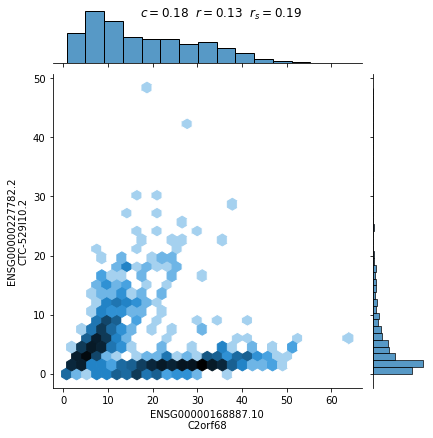

'Index: 19'

('ENSG00000142599.17', 'ENSG00000100226.15')

('RERE', 'GTPBP1')

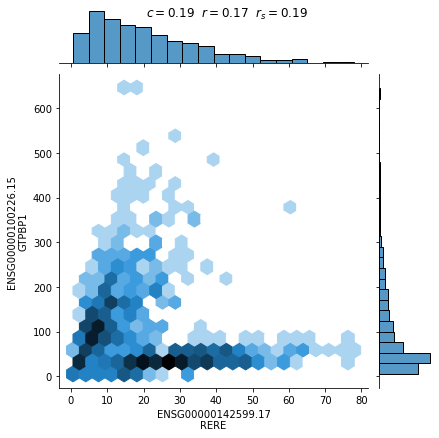

'Index: 20'

('ENSG00000140455.16', 'ENSG00000100226.15')

('USP3', 'GTPBP1')

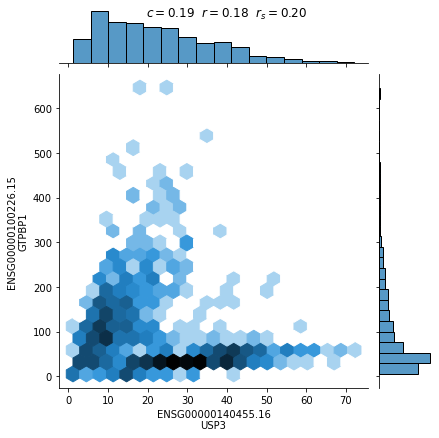

'Index: 21'

('ENSG00000107771.15', 'ENSG00000185905.3')

('CCSER2', 'C16orf54')

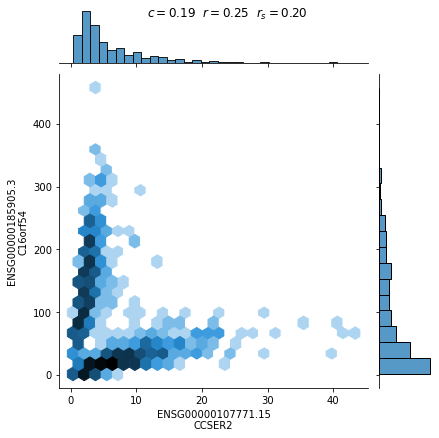

'Index: 22'

('ENSG00000171608.15', 'ENSG00000100226.15')

('PIK3CD', 'GTPBP1')

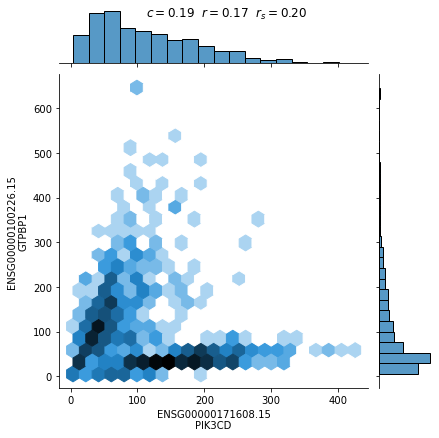

'Index: 23'

('ENSG00000205045.8', 'ENSG00000130772.13')

('SLFN12L', 'MED18')

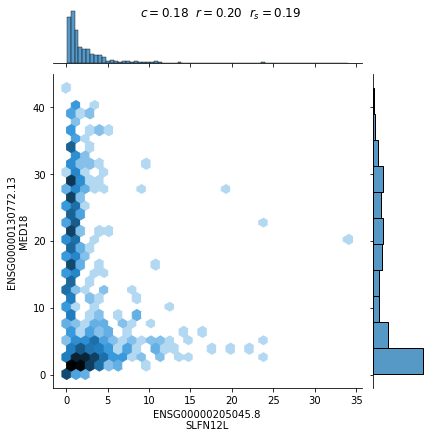

'Index: 24'

('ENSG00000198001.13', 'ENSG00000100226.15')

('IRAK4', 'GTPBP1')

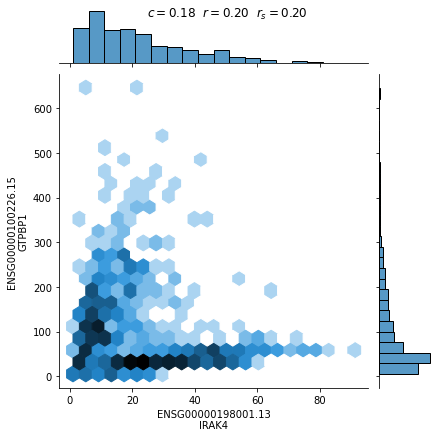

'Index: 25'

('ENSG00000059804.15', 'ENSG00000174125.7')

('SLC2A3', 'TLR1')

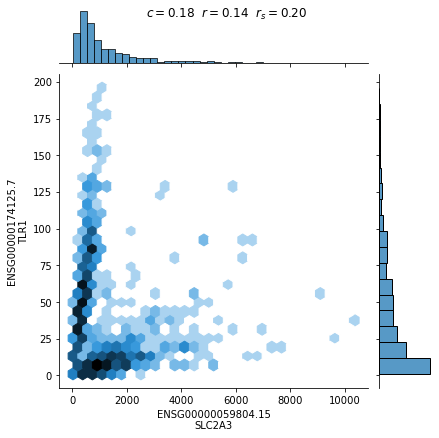

'Index: 26'

('ENSG00000110057.7', 'ENSG00000100226.15')

('UNC93B1', 'GTPBP1')

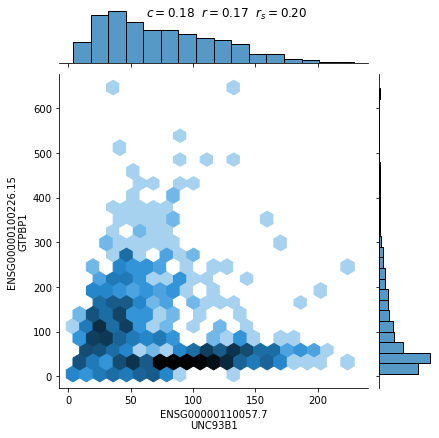

'Index: 27'

('ENSG00000107771.15', 'ENSG00000166272.16')

('CCSER2', 'WBP1L')

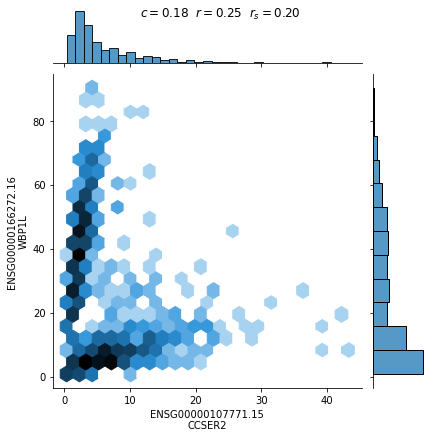

In [72]:
for i in range(_tmp_df.shape[0]):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Clustermatch vs Spearman/Pearson

In [73]:
first_coef = "clustermatch"
second_coefs = ("spearman", "pearson")

In [74]:
_tmp_df = df_r_data[
    (df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & (df_r_data["Spearman (low)"])
    & (df_r_data["Pearson (low)"])
]

if len(second_coefs) > 1:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"].add(
        _tmp_df[f"{second_coefs[1]}_rank"]
    )
else:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"]

_tmp_df = _tmp_df.assign(rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_second_coefs_sum))

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df.sort_values("rank_diff", ascending=False)

# # sort by firt_coef value
# _tmp_df = _tmp_df.sort_values(
#     first_coef, ascending=False
# )

_tmp_df = _tmp_df[
    [x for x in _tmp_df.columns if "(high)" not in x and "(low)" not in x]
]

display(_tmp_df.shape)
display(_tmp_df)

(8, 7)

,,clustermatch,pearson,spearman,clustermatch_rank,pearson_rank,spearman_rank,rank_diff
ENSG00000189114.6,ENSG00000278330.1,0.188812,0.028556,0.192653,8897293.5,1043401.0,3636575.0,4217317.5
ENSG00000125319.14,ENSG00000088325.15,0.183514,0.069207,0.134905,8802636.0,2385010.0,2621517.0,3796109.0
ENSG00000162413.16,ENSG00000235027.1,0.184217,0.062875,0.186421,8813629.5,2188393.0,3530425.0,3094811.5
ENSG00000170871.11,ENSG00000229598.1,0.181940,0.067078,0.182466,8771662.0,2319153.0,3463190.0,2989319.0
ENSG00000251474.6,ENSG00000229598.1,0.193464,0.073375,0.186682,8979610.0,2512718.0,3534806.0,2932086.0
ENSG00000225963.7,ENSG00000229598.1,0.184279,0.070892,0.197203,8823932.0,2437032.0,3713281.0,2673619.0
ENSG00000101152.10,ENSG00000100226.15,0.193464,0.107576,0.156998,8979610.0,3482451.0,3018450.0,2478709.0
ENSG00000100055.20,ENSG00000100226.15,0.184217,0.087254,0.183848,8813629.5,2922303.0,3486726.0,2404600.5


'Index: 0'

('ENSG00000189114.6', 'ENSG00000278330.1')

('BLOC1S3', 'RP11-4B16.4')

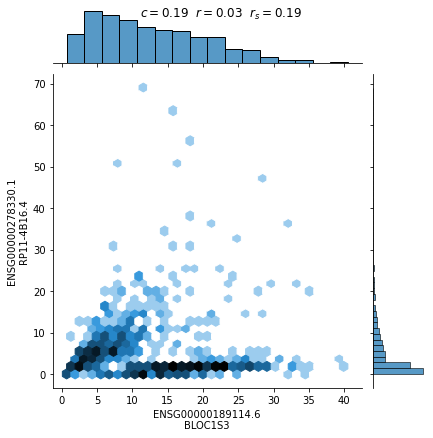

'Index: 1'

('ENSG00000125319.14', 'ENSG00000088325.15')

('C17orf53', 'TPX2')

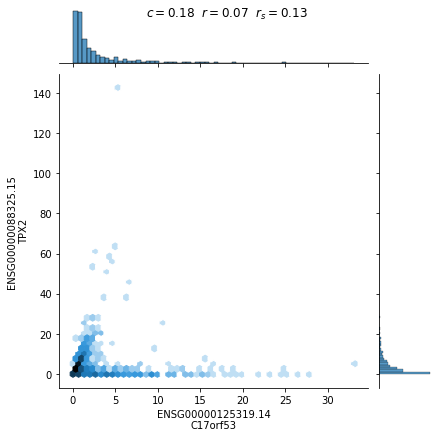

'Index: 2'

('ENSG00000162413.16', 'ENSG00000235027.1')

('KLHL21', 'AC068580.6')

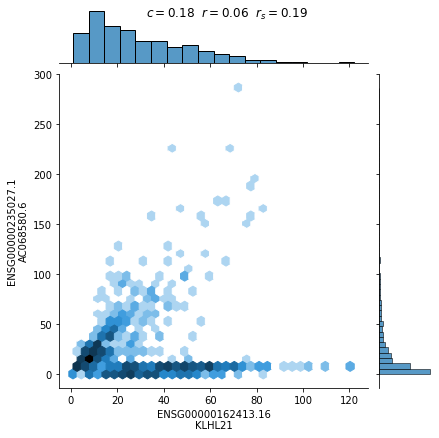

'Index: 3'

('ENSG00000170871.11', 'ENSG00000229598.1')

('KIAA0232', 'PRDX3P1')

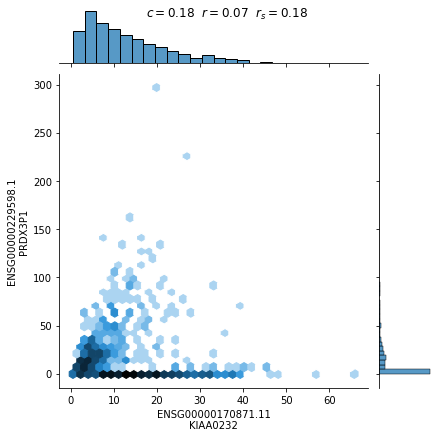

'Index: 4'

('ENSG00000251474.6', 'ENSG00000229598.1')

('RPL32P3', 'PRDX3P1')

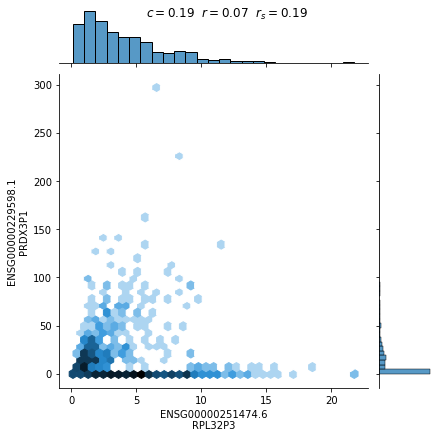

'Index: 5'

('ENSG00000225963.7', 'ENSG00000229598.1')

('AC009950.2', 'PRDX3P1')

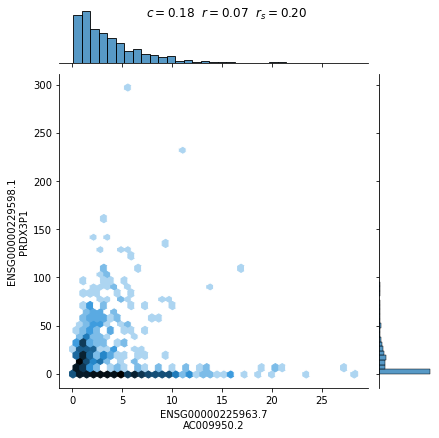

'Index: 6'

('ENSG00000101152.10', 'ENSG00000100226.15')

('DNAJC5', 'GTPBP1')

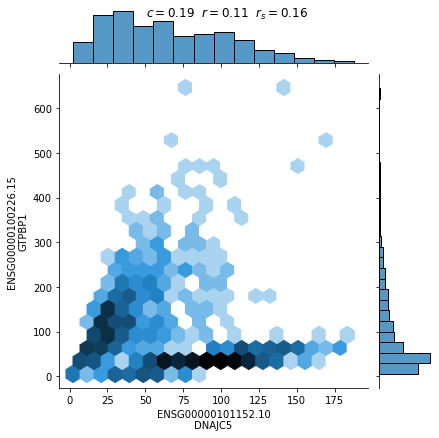

'Index: 7'

('ENSG00000100055.20', 'ENSG00000100226.15')

('CYTH4', 'GTPBP1')

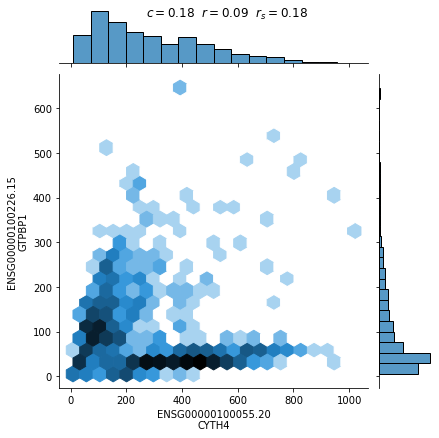

In [75]:
for i in range(_tmp_df.shape[0]):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Pearson vs Clustermatch

In [76]:
first_coef = "pearson"
second_coefs = ("clustermatch",)

In [77]:
_tmp_df = df_r_data[
    ~(df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & (df_r_data["Pearson (high)"])
    & (df_r_data["Clustermatch (low)"])
    & ~(df_r_data["Spearman (low)"])
    & ~(df_r_data["Pearson (low)"])
]

if len(second_coefs) > 1:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"].add(
        _tmp_df[f"{second_coefs[1]}_rank"]
    )
else:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"]

_tmp_df = _tmp_df.assign(rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_second_coefs_sum))

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df.sort_values("rank_diff", ascending=False)

# # sort by firt_coef value
# _tmp_df = _tmp_df.sort_values(
#     first_coef, ascending=False
# )

_tmp_df = _tmp_df[
    [x for x in _tmp_df.columns if "(high)" not in x and "(low)" not in x]
]

display(_tmp_df.shape)
display(_tmp_df)

(1075, 7)

clustermatch   pearson  spearman  \
ENSG00000086967.9  ENSG00000185482.7       0.013219  0.773951  0.219206   
ENSG00000139194.7  ENSG00000118137.9       0.014090  0.774653  0.201909   
ENSG00000185482.7  ENSG00000180209.11      0.013443  0.731125  0.221139   
                   ENSG00000168530.15      0.017339  0.773344  0.204705   
ENSG00000139194.7  ENSG00000172482.4       0.021694  0.855637  0.222971   
...                                             ...       ...       ...   
ENSG00000147669.10 ENSG00000196839.12      0.034593  0.435534  0.305998   
ENSG00000198885.9  ENSG00000004700.15      0.034657  0.435656  0.323576   
ENSG00000163938.16 ENSG00000269952.1       0.034782  0.436373  0.288694   
ENSG00000112739.16 ENSG00000168056.15      0.034910  0.436436  0.361032   
ENSG00000135048.13 ENSG00000103257.8       0.034894  0.435569  0.254709   

                                       clustermatch_rank  pearson_rank  \
ENSG00000086967.9  ENSG00000185482.7           1268069.0    11967853.0   
ENSG00000139194.7  ENSG00000118137.9           1386940.5    11972528.0   
ENSG00000185482.7  ENSG00000180209.11          1299979.0    11650044.0   
                   ENSG00000168530.15          1822862.5    11963627.0   
ENSG00000139194.7  ENSG00000172482.4           2366502.0    12377367.0   
...                                                  ...           ...   
ENSG00000147669.10 ENSG00000196839.12          3714425.5     8756919.0   
ENSG00000198885.9  ENSG00000004700.15          3728526.0     8758165.0   
ENSG00000163938.16 ENSG00000269952.1           3736377.5     8765729.0   
ENSG00000112739.16 ENSG00000168056.15          3745667.5     8766382.0   
ENSG00000135048.13 ENSG00000103257.8           3744626.5     8757270.0   

                                       spearman_rank   rank_diff  
ENSG00000086967.9  ENSG00000185482.7       4074647.0  10699784.0  
ENSG00000139194.7  ENSG00000118137.9       3791784.0  10585587.5  
ENSG00000185482.7  ENSG00000180209.11      4105691.0  10350065.0  
                   ENSG00000168530.15      3838118.0  10140764.5  
ENSG00000139194.7  ENSG00000172482.4       4135107.0  10010865.0  
...                                              ...         ...  
ENSG00000147669.10 ENSG00000196839.12      5387221.0   5042493.5  
ENSG00000198885.9  ENSG00000004700.15      5638256.0   5029639.0  
ENSG00000163938.16 ENSG00000269952.1       5135802.0   5029351.5  
ENSG00000112739.16 ENSG00000168056.15      6159595.0   5020714.5  
ENSG00000135048.13 ENSG00000103257.8       4630426.0   5012643.5  

[1075 rows x 7 columns]

'Index: 0'

('ENSG00000086967.9', 'ENSG00000185482.7')

('MYBPC2', 'STAC3')

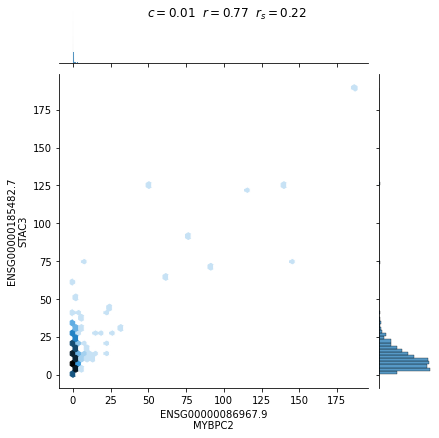

'Index: 1'

('ENSG00000139194.7', 'ENSG00000118137.9')

('RBP5', 'APOA1')

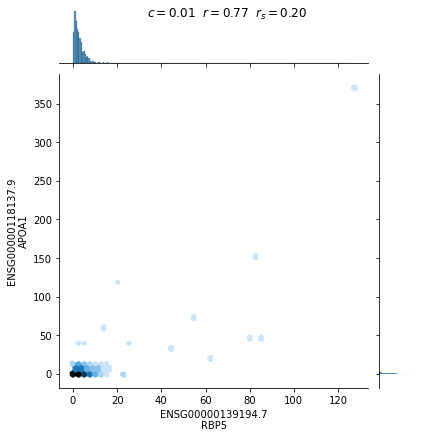

'Index: 2'

('ENSG00000185482.7', 'ENSG00000180209.11')

('STAC3', 'MYLPF')

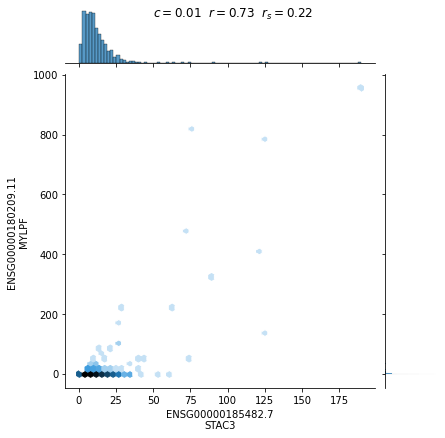

'Index: 3'

('ENSG00000185482.7', 'ENSG00000168530.15')

('STAC3', 'MYL1')

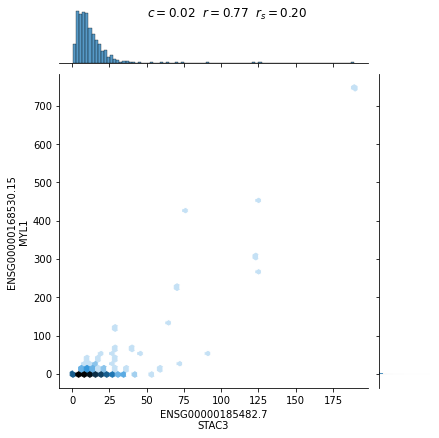

'Index: 4'

('ENSG00000139194.7', 'ENSG00000172482.4')

('RBP5', 'AGXT')

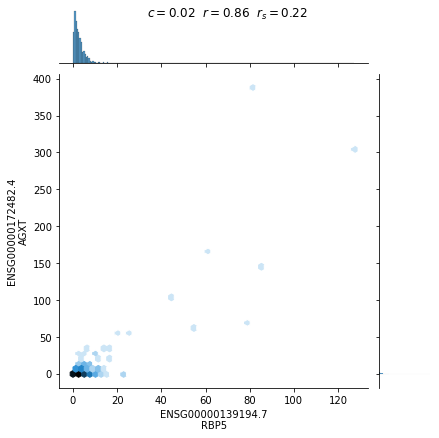

In [78]:
for i in range(min(_tmp_df.shape[0], 5)):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Pearson vs Spearman

In [79]:
first_coef = "pearson"
second_coefs = ("spearman",)

In [80]:
_tmp_df = df_r_data[
    ~(df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & (df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & (df_r_data["Spearman (low)"])
    & ~(df_r_data["Pearson (low)"])
]

if len(second_coefs) > 1:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"].add(
        _tmp_df[f"{second_coefs[1]}_rank"]
    )
else:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"]

_tmp_df = _tmp_df.assign(rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_second_coefs_sum))

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df.sort_values("rank_diff", ascending=False)

# # sort by firt_coef value
# _tmp_df = _tmp_df.sort_values(
#     first_coef, ascending=False
# )

_tmp_df = _tmp_df[
    [x for x in _tmp_df.columns if "(high)" not in x and "(low)" not in x]
]

display(_tmp_df.shape)
display(_tmp_df)

(87, 7)

clustermatch   pearson  spearman  \
ENSG00000116285.12 ENSG00000133800.8       0.035512  0.681890  0.014864   
ENSG00000169385.2  ENSG00000186652.9       0.042113  0.685558  0.031171   
                   ENSG00000156575.2       0.037713  0.646452  0.027049   
ENSG00000086061.15 ENSG00000106211.8       0.039391  0.576402  0.018334   
ENSG00000133800.8  ENSG00000130203.9       0.043544  0.562120  0.020988   
...                                             ...       ...       ...   
ENSG00000187010.19 ENSG00000213088.9       0.041549  0.445331  0.193599   
ENSG00000152332.15 ENSG00000090104.11      0.085697  0.448579  0.197677   
ENSG00000108669.16 ENSG00000269952.1       0.036257  0.441428  0.199235   
ENSG00000109606.12 ENSG00000269919.1       0.035931  0.436786  0.196683   
ENSG00000143772.9  ENSG00000090104.11      0.061686  0.437508  0.197910   

                                       clustermatch_rank  pearson_rank  \
ENSG00000116285.12 ENSG00000133800.8           3784002.0    11223355.0   
ENSG00000169385.2  ENSG00000186652.9           4324263.5    11256632.0   
                   ENSG00000156575.2           3989023.0    10890348.0   
ENSG00000086061.15 ENSG00000106211.8           4106391.0    10196289.0   
ENSG00000133800.8  ENSG00000130203.9           4417514.5    10051096.0   
...                                                  ...           ...   
ENSG00000187010.19 ENSG00000213088.9           4269576.0     8858911.0   
ENSG00000152332.15 ENSG00000090104.11          6404343.0     8892335.0   
ENSG00000108669.16 ENSG00000269952.1           3855062.0     8818646.0   
ENSG00000109606.12 ENSG00000269919.1           3835012.0     8770053.0   
ENSG00000143772.9  ENSG00000090104.11          5468551.0     8777681.0   

                                       spearman_rank   rank_diff  
ENSG00000116285.12 ENSG00000133800.8        302353.0  10921002.0  
ENSG00000169385.2  ENSG00000186652.9        632265.0  10624367.0  
                   ENSG00000156575.2        548886.0  10341462.0  
ENSG00000086061.15 ENSG00000106211.8        372749.0   9823540.0  
ENSG00000133800.8  ENSG00000130203.9        426427.0   9624669.0  
...                                              ...         ...  
ENSG00000187010.19 ENSG00000213088.9       3652622.0   5206289.0  
ENSG00000152332.15 ENSG00000090104.11      3721047.0   5171288.0  
ENSG00000108669.16 ENSG00000269952.1       3747250.0   5071396.0  
ENSG00000109606.12 ENSG00000269919.1       3704391.0   5065662.0  
ENSG00000143772.9  ENSG00000090104.11      3724918.0   5052763.0  

[87 rows x 7 columns]

'Index: 0'

('ENSG00000116285.12', 'ENSG00000133800.8')

('ERRFI1', 'LYVE1')

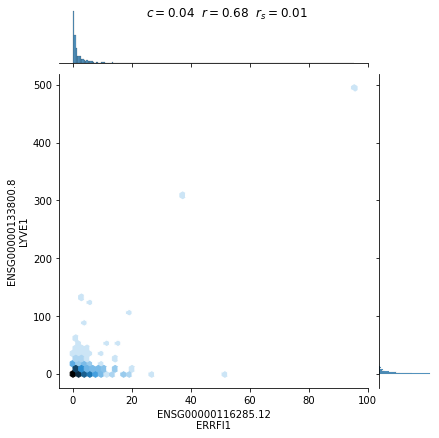

'Index: 1'

('ENSG00000169385.2', 'ENSG00000186652.9')

('RNASE2', 'PRG2')

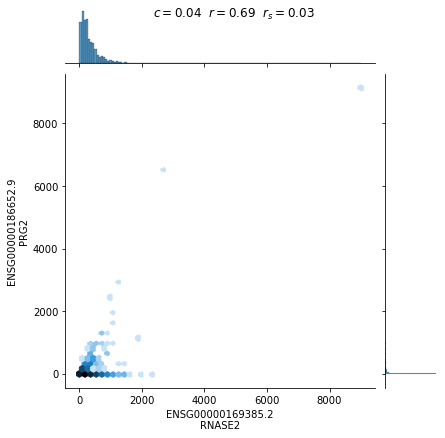

'Index: 2'

('ENSG00000169385.2', 'ENSG00000156575.2')

('RNASE2', 'PRG3')

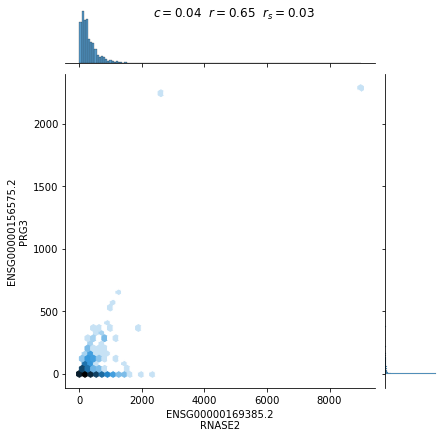

'Index: 3'

('ENSG00000086061.15', 'ENSG00000106211.8')

('DNAJA1', 'HSPB1')

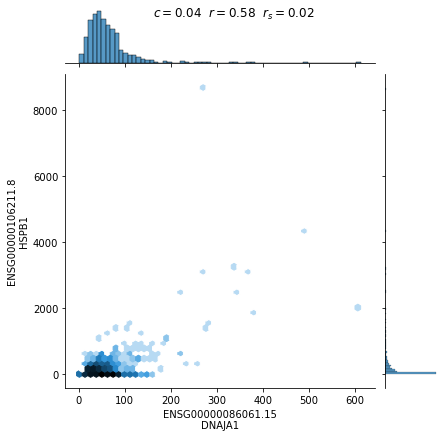

'Index: 4'

('ENSG00000133800.8', 'ENSG00000130203.9')

('LYVE1', 'APOE')

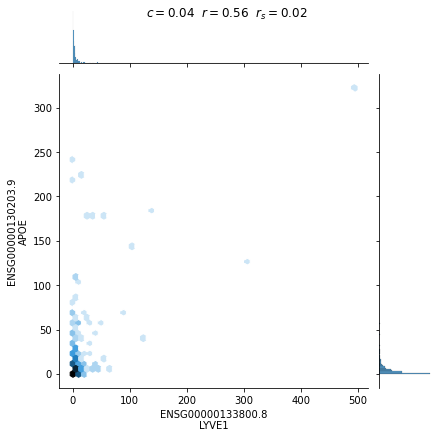

In [81]:
for i in range(min(_tmp_df.shape[0], 5)):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Pearson vs Spearman/Clustermatch

In [82]:
first_coef = "pearson"
second_coefs = ("spearman", "clustermatch")

In [83]:
_tmp_df = df_r_data[
    ~(df_r_data["Clustermatch (high)"])
    & ~(df_r_data["Spearman (high)"])
    & (df_r_data["Pearson (high)"])
    & (df_r_data["Clustermatch (low)"])
    & (df_r_data["Spearman (low)"])
    & ~(df_r_data["Pearson (low)"])
]

if len(second_coefs) > 1:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"].add(
        _tmp_df[f"{second_coefs[1]}_rank"]
    )
else:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"]

_tmp_df = _tmp_df.assign(rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_second_coefs_sum))

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df.sort_values("rank_diff", ascending=False)

# # sort by firt_coef value
# _tmp_df = _tmp_df.sort_values(
#     first_coef, ascending=False
# )

_tmp_df = _tmp_df[
    [x for x in _tmp_df.columns if "(high)" not in x and "(low)" not in x]
]

display(_tmp_df.shape)
display(_tmp_df)

(531, 7)

,,clustermatch,pearson,spearman,clustermatch_rank,pearson_rank,spearman_rank,rank_diff
ENSG00000167644.11,ENSG00000161055.3,0.002391,0.786861,0.001743,34495.5,12051527.0,35371.0,11981660.5
ENSG00000214274.9,ENSG00000118137.9,0.008307,0.797156,0.011672,617129.5,12113159.0,237688.0,11258341.5
ENSG00000105519.15,ENSG00000081041.8,0.006144,0.731259,0.003654,348738.5,11651140.0,74026.0,11228375.5
ENSG00000124145.6,ENSG00000161055.3,0.003760,0.766504,0.032290,111394.0,11917143.0,654786.0,11150963.0
ENSG00000167644.11,ENSG00000165272.14,0.001355,0.726970,0.034726,8636.0,11616259.0,704150.0,10903473.0
...,...,...,...,...,...,...,...,...
ENSG00000105011.8,ENSG00000077152.9,0.034551,0.469123,0.174012,3702036.0,9104440.0,3316972.0,2085432.0
ENSG00000120306.9,ENSG00000118113.11,0.029537,0.449291,0.190795,3235206.0,8899852.0,3605113.0,2059533.0
ENSG00000133872.13,ENSG00000269919.1,0.030704,0.450809,0.191052,3364875.0,8915612.0,3609390.0,1941347.0
ENSG00000173868.11,ENSG00000100228.12,0.034335,0.472668,0.193791,3688340.0,9140833.0,3655826.0,1796667.0


'Index: 0'

('ENSG00000167644.11', 'ENSG00000161055.3')

('C19orf33', 'SCGB3A1')

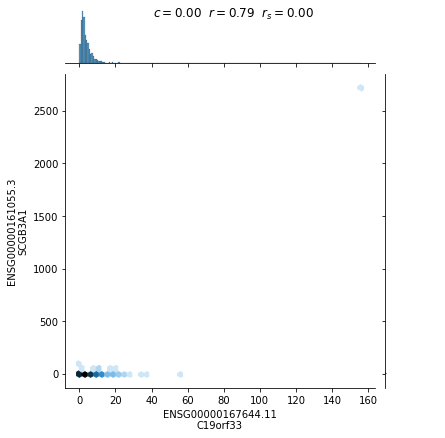

'Index: 1'

('ENSG00000214274.9', 'ENSG00000118137.9')

('ANG', 'APOA1')

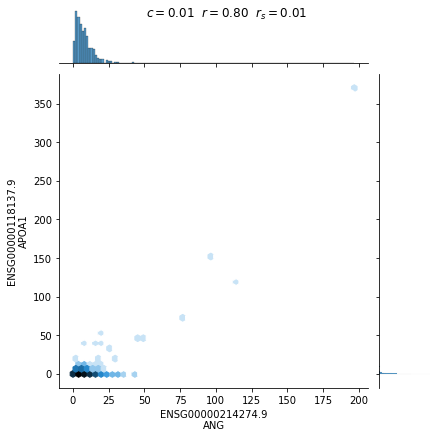

'Index: 2'

('ENSG00000105519.15', 'ENSG00000081041.8')

('CAPS', 'CXCL2')

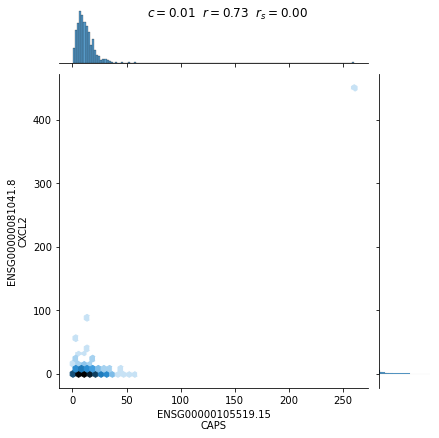

'Index: 3'

('ENSG00000124145.6', 'ENSG00000161055.3')

('SDC4', 'SCGB3A1')

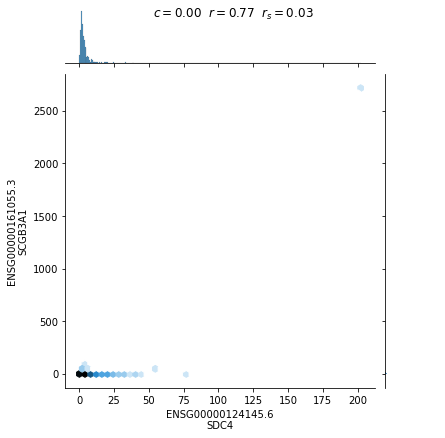

'Index: 4'

('ENSG00000167644.11', 'ENSG00000165272.14')

('C19orf33', 'AQP3')

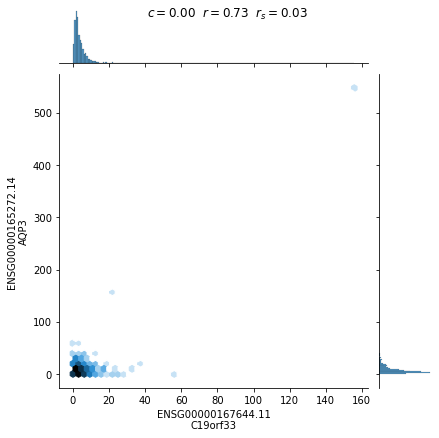

In [84]:
for i in range(min(_tmp_df.shape[0], 5)):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)

## Spearman vs Pearson

In [85]:
first_coef = "spearman"
second_coefs = ("pearson",)

In [86]:
_tmp_df = df_r_data[
    ~(df_r_data["Clustermatch (high)"])
    & (df_r_data["Spearman (high)"])
    & ~(df_r_data["Pearson (high)"])
    & ~(df_r_data["Clustermatch (low)"])
    & ~(df_r_data["Spearman (low)"])
    & (df_r_data["Pearson (low)"])
]

if len(second_coefs) > 1:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"].add(
        _tmp_df[f"{second_coefs[1]}_rank"]
    )
else:
    _second_coefs_sum = _tmp_df[f"{second_coefs[0]}_rank"]

_tmp_df = _tmp_df.assign(rank_diff=_tmp_df[f"{first_coef}_rank"].sub(_second_coefs_sum))

# show this just to make sure of the groups
# display(_tmp_df.head())

# sort by rank_diff
_tmp_df = _tmp_df.sort_values("rank_diff", ascending=False)

# # sort by firt_coef value
# _tmp_df = _tmp_df.sort_values(
#     first_coef, ascending=False
# )

_tmp_df = _tmp_df[
    [x for x in _tmp_df.columns if "(high)" not in x and "(low)" not in x]
]

display(_tmp_df.shape)
display(_tmp_df)

(527, 7)

,,clustermatch,pearson,spearman,clustermatch_rank,pearson_rank,spearman_rank,rank_diff
ENSG00000103111.14,ENSG00000213931.5,0.172974,0.013313,0.578902,8602668.0,492233.0,8943352.0,8451119.0
ENSG00000211976.2,ENSG00000253998.3,0.164233,0.018452,0.579442,8430572.5,680432.0,8949752.0,8269320.0
ENSG00000165272.14,ENSG00000211976.2,0.168576,0.022240,0.588749,8516910.5,817549.0,9061155.0,8243606.0
ENSG00000133800.8,ENSG00000152463.14,0.166398,0.024815,0.588466,8473581.5,910272.0,9057794.0,8147522.0
ENSG00000147439.12,ENSG00000213931.5,0.179678,0.027089,0.585141,8729510.0,991263.0,9018211.0,8026948.0
...,...,...,...,...,...,...,...,...
ENSG00000229769.2,ENSG00000142173.14,0.164233,0.116920,0.568660,8430572.5,3725799.0,8819928.0,5094129.0
ENSG00000211952.3,ENSG00000165272.14,0.164233,0.116661,0.566400,8430572.5,3719250.0,8792542.0,5073292.0
ENSG00000139194.7,ENSG00000108582.11,0.172974,0.116929,0.564354,8602668.0,3726017.0,8767784.0,5041767.0
ENSG00000127884.4,ENSG00000211749.1,0.170768,0.116364,0.562867,8559745.0,3711660.0,8749764.0,5038104.0


'Index: 0'

('ENSG00000103111.14', 'ENSG00000213931.5')

('MON1B', 'HBE1')

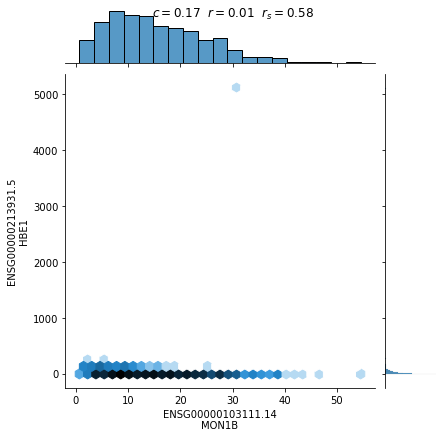

'Index: 1'

('ENSG00000211976.2', 'ENSG00000253998.3')

('IGHV3-73', 'IGKV2-29')

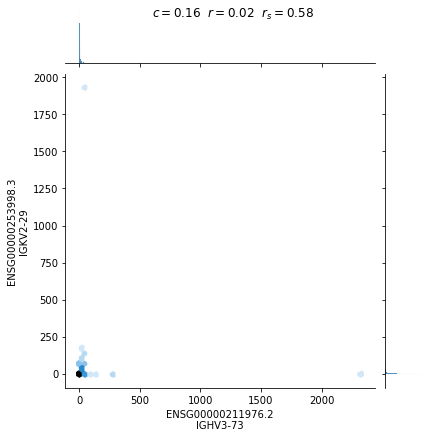

'Index: 2'

('ENSG00000165272.14', 'ENSG00000211976.2')

('AQP3', 'IGHV3-73')

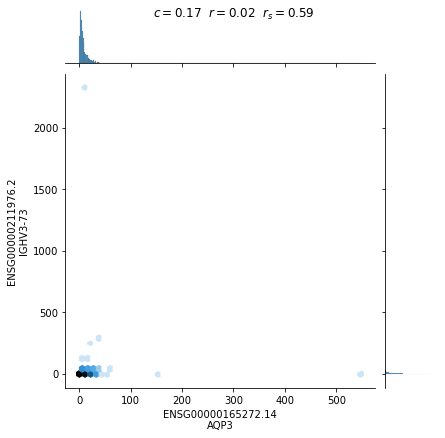

'Index: 3'

('ENSG00000133800.8', 'ENSG00000152463.14')

('LYVE1', 'OLAH')

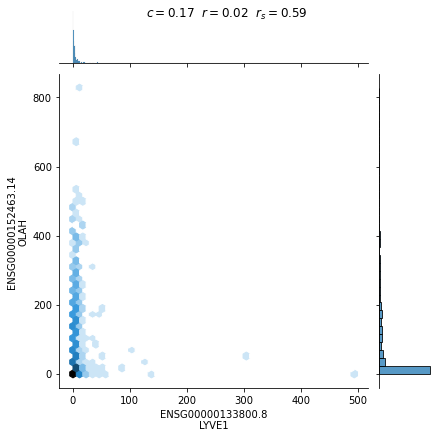

'Index: 4'

('ENSG00000147439.12', 'ENSG00000213931.5')

('BIN3', 'HBE1')

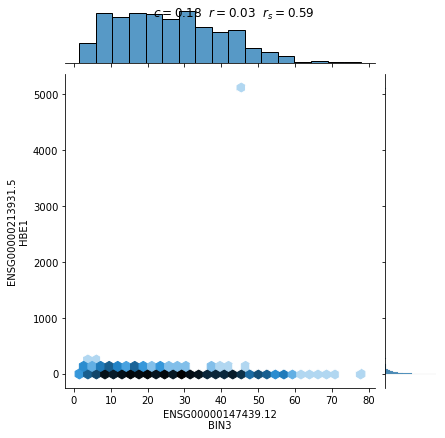

In [87]:
for i in range(min(_tmp_df.shape[0], 5)):
    display(f"Index: {i}")
    p = plot_gene_pair(_tmp_df, i)
    display(p.fig)
    plt.close(p.fig)